## Условие задачи
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

### Описание данных

<li> contract.csv - информация о договоре; </li>
<li> personal.csv — персональные данные клиента; </li>
<li> internet.csv — информация об интернет-услугах; </li>
<li> phone.csv — информация об услугах телефонии. </li>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
C:\Users\96037\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\96037\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\96037\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\96037\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
# Загрузка датафреймов
df_contract = pd.read_csv('D:/Data science/data/contract.csv')
df_internet = pd.read_csv('D:/Data science/data/internet.csv')
df_personal = pd.read_csv('D:/Data science/data/personal.csv')
df_phone = pd.read_csv('D:/Data science/data/phone.csv')

In [3]:
# Объединение датафреймов
df = df_contract.merge(df_personal, on = 'customerID')
df = df.merge(df_internet, on = 'customerID', how = 'left')
df = df.merge(df_phone, on = 'customerID', how = 'left')

In [4]:
# Замена всех пропусков на No
df['MultipleLines'] = df['MultipleLines'].fillna('No phone')
df = df.fillna('No')

In [5]:
# Использование категоризации
def client_outflow(enddate):
    if enddate == 'No':
        return 'No'
    if enddate != 'No':
        return 'Yes'
df['ClientOutflow'] = df['EndDate'].apply(client_outflow)

In [6]:
df['MonthlyCharges'] = df['MonthlyCharges'].astype('float32')
df['SeniorCitizen'] = np.int_(df['SeniorCitizen'])
df['TotalCharges'] = df['TotalCharges'].replace(" ", 0).astype('float32')

In [7]:
# Информация актуальна на 1 февраля 2020, поэтому проведем нехитрую операцию
df['EndDate'] = df['EndDate'].replace('No', '2020-02-01 00:00:00')
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')

In [8]:
# Нахождение количества месяцев 
#df['summary_month'] = ((pd.DatetimeIndex(df['EndDate']).year  
#               - pd.DatetimeIndex(df['BeginDate']).year)*12 
#               + pd.DatetimeIndex(df['EndDate']).month 
#               - pd.DatetimeIndex(df['BeginDate']).month)
#df['summary_month'] = np.int_(df['summary_month'])

In [9]:
# Добавление месяца и года присоединения клиента в компанию
df['BeginMonth'] = pd.DatetimeIndex(df['BeginDate']).month
df['BeginMonth'] = np.int_(df['BeginMonth'])
df['BeginYear'] = pd.DatetimeIndex(df['BeginDate']).year
df['BeginYear'] = np.int_(df['BeginYear'])

In [10]:
# Функции добавления новых категориальных признаков 
def is_phone(phone):
    if phone == 'No phone':
        return 0
    if phone != 'No phone':
        return 1
#df['is_phone'] = df['MultipleLines'].apply(is_phone)
#df['is_phone'] = np.int_(df['is_phone'])
#df['MultipleLines'] = df['MultipleLines'].replace('No', 0).replace('Yes', 1).replace('No phone', 2)
#df['MultipleLines'] = df['MultipleLines'].astype('int')

def is_internet(internet):
    if internet == 'No':
        return 0
    if internet != 'No':
        return 1
df['is_internet'] = df['InternetService'].apply(is_internet)
df['is_internet'] = np.int_(df['is_internet'])
df['InternetService'] = df['InternetService'].replace('DSL', 0).replace('Fiber optic', 1).replace('No', 2)
df['InternetService'] = df['InternetService'].astype('int')

df['protect'] = df['OnlineSecurity'] + df['DeviceProtection']
def protect(protect):
    if protect == 'NoNo':
        return 0
    if protect != 'NoNo':
        return 1
df['is_protect'] = df['protect'].apply(protect)
df['is_protect'] = np.int_(df['is_protect'])
df = df.drop(['protect', 'OnlineSecurity', 'DeviceProtection'], axis = 1)

In [11]:
def category_totalcharges(totalcharges) :   
    if totalcharges <= 2000 :
        return 0
    if (totalcharges > 2000) & (totalcharges <= 4000):
        return 1
    if (totalcharges > 4000) & (totalcharges <= 6000):
        return 2
    if totalcharges > 6000:
        return 3
#df['totalcharges_group'] = df['TotalCharges'].apply(category_totalcharges)
#df['totalcharges_group'] = np.int_(df['totalcharges_group'])
def category_monthlycharges(monthlycharges) :   
    if monthlycharges <= 30 :
        return 0
    if (monthlycharges > 30) & (monthlycharges <= 70 ):
        return 1
    if (monthlycharges > 70) & (monthlycharges <= 99 ):
        return 2
    if monthlycharges > 99 :
        return 3
df['monthlycharges_group'] = df['MonthlyCharges'].apply(category_monthlycharges)
df['monthlycharges_group'] = np.int_(df['monthlycharges_group'])

In [12]:
# Удаление ненужных столбцов
df = df.drop(['customerID', 'BeginDate', 'EndDate', 'gender', 'MonthlyCharges'], axis=1)

In [13]:
# Перевод всех объектов в численные значения
def object_to_int(df):
    if df.dtype=='object':
        df = LabelEncoder().fit_transform(df)
    return df
df = df.apply(lambda x: object_to_int(x))

In [14]:
# Применение прямого кодирования и добавление полиномиальных признаков
df_gd = df.drop(['ClientOutflow', 'TotalCharges', 'Type', 'monthlycharges_group','BeginMonth', 'PaymentMethod'], axis = 1)
df = pd.get_dummies(df, columns = df_gd.columns, drop_first = True)
df = df.drop(['InternetService_2'], axis = 1)
def add_polynomial_features(frame, poly_degree=2, interaction=False):
    poly = PolynomialFeatures(degree=poly_degree, interaction_only=interaction, include_bias=False)
    poly_features = poly.fit_transform(frame[['TotalCharges']])
    df_poly = pd.DataFrame(poly_features, columns=poly.get_feature_names())
    return pd.concat([frame, df_poly.drop(['x0'], axis=1)], axis=1)
df = add_polynomial_features(df, 3, False)

In [15]:
# Разбивка датасета на тренировочную, валидационную и тестовую выборки
df_train, df_test = train_test_split(df, test_size=0.2, random_state=12345)
df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=12345)
X_train = df_train.drop(['ClientOutflow'], axis=1)
y_train = df_train['ClientOutflow']
X_valid = df_valid.drop(['ClientOutflow'], axis=1)
y_valid = df_valid['ClientOutflow']
X_test = df_test.drop(['ClientOutflow'], axis=1)
y_test = df_test['ClientOutflow']

In [16]:
# Cтандартизация численных значений
numeric = []
for i in df.columns:
    if df[i].dtype =='float64' or df[i].dtype =='float32':
        numeric += [i]
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [17]:
# Скажем дисбалансу "NO!"
print('Перед OverSampling, shape для X_train:', X_train.shape)
print('Перед OverSampling, shape для целового признака:', y_train.shape)
print('Перед OverSampling, y_train count: "1": ушел клиент:', sum(y_train == 1))
print('Перед OverSampling, y_train count: "0": остался:', sum(y_train == 0))

sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

print('После OverSampling, shape для X_train:', X_train.shape)
print('После OverSampling, shape для целового признака:', y_train.shape)

print('После OverSampling, количество: "1": ушел клиент:', sum(y_train == 1))
print('После OverSampling, количество: "0": остался:', sum(y_train == 0))

Перед OverSampling, shape для X_train: (4225, 27)
Перед OverSampling, shape для целового признака: (4225,)
Перед OverSampling, y_train count: "1": ушел клиент: 1137
Перед OverSampling, y_train count: "0": остался: 3088
После OverSampling, shape для X_train: (6176, 27)
После OverSampling, shape для целового признака: (6176,)
После OverSampling, количество: "1": ушел клиент: 3088
После OverSampling, количество: "0": остался: 3088


### Logistic Regression

In [18]:
lr = LogisticRegression(random_state = 12345, multi_class = 'ovr')
parameters_lr = {'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                 'penalty':['l1', 'l2', 'elasticnet', 'none'], 
                 'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
search_lr = RandomizedSearchCV(lr, parameters_lr, cv=5)
search_lr.fit(X_train, y_train)
best_lr = search_lr.best_estimator_
predict_lr = best_lr.predict(X_valid)
score_lr = cross_val_score(best_lr, X_valid, y_valid, scoring = 'roc_auc', cv = 10, n_jobs = -1)
print('AUC-ROC для Logistic Regression на валидационной выборке:', sum(score_lr)/len(score_lr))
print('Accuracy для Logistic Regression на валидационной выборке:', accuracy_score(y_valid, predict_lr))

AUC-ROC для Logistic Regression на валидационной выборке: 0.8347993553815657
Accuracy для Logistic Regression на валидационной выборке: 0.7608232789212207


In [19]:
def confusion_m(model, title):
    cm = confusion_matrix(y_test, model.predict(X_test))
    f, ax = plt.subplots(figsize = (5, 5))
    sns.heatmap(cm, annot = True, linewidths = 0.5, color = 'red', fmt = '.0f', ax = ax)
    plt.xlabel('y_predicted')
    plt.ylabel('y_true')
    plt.title(title)
    plt.show()

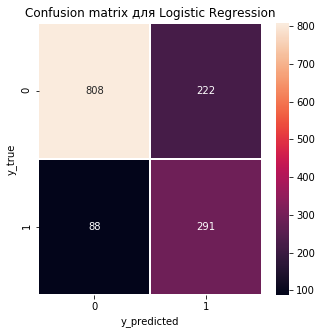

In [20]:
confusion_m(best_lr, 'Confusion matrix для Logistic Regression')

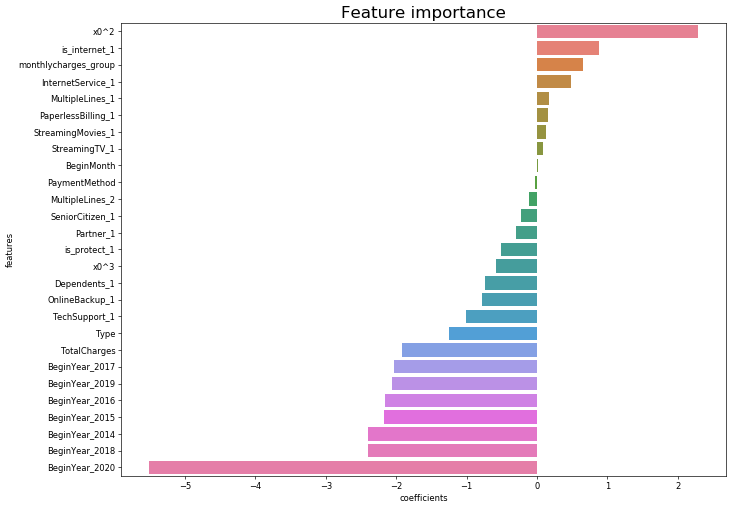

In [21]:
def feature_importance(model):
    dataframe = pd.DataFrame(model, X_train.columns).reset_index()
    dataframe = dataframe.rename(columns = {'index':'features', 0:'coefficients'})
    dataframe = dataframe.sort_values(by = 'coefficients', ascending = False)
    plt.figure(figsize=(13,10), dpi= 60)
    ax = sns.barplot(x = 'coefficients', y = 'features', data = dataframe ,palette = 'husl')
    plt.title('Feature importance', fontsize = 20)
feature_importance(best_lr.coef_[0])

### Random Forest

In [22]:
rf = RandomForestClassifier(random_state = 12345)
parameters_rf = {'n_estimators': range(1, 501, 100), 
                 'criterion': ['gini', 'entropy'], 
                 'max_depth':range(1, 50, 2), 
                 'min_samples_split': range(1, 10), 
                 'min_samples_leaf': range(1, 10), 
                 'max_features':['auto', 'log2', 'sqrt', 'None']}
search_rf = RandomizedSearchCV(rf, parameters_rf, cv=5, n_jobs = -1)
search_rf.fit(X_train, y_train)
best_rf = search_rf.best_estimator_
predict_rf = best_rf.predict(X_valid)
score_rf = cross_val_score(best_rf, X_valid, y_valid, scoring = 'roc_auc', cv = 10, n_jobs = -1) 
print('AUC-ROC для Random Forest на валидационной выборке:', sum(score_rf)/len(score_rf))
print('Accuracy для Random Forest на валидационной выборке:', accuracy_score(y_valid, predict_rf))

AUC-ROC для Random Forest на валидационной выборке: 0.8588632752891513
Accuracy для Random Forest на валидационной выборке: 0.8176011355571328


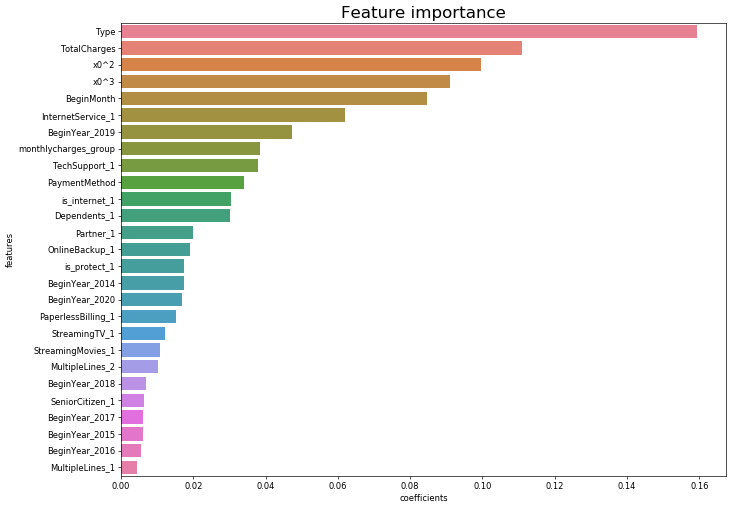

In [23]:
feature_importance(best_rf.feature_importances_)

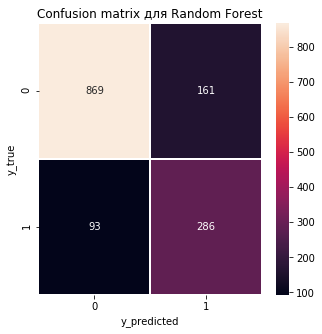

In [24]:
confusion_m(best_rf, 'Confusion matrix для Random Forest')

### XGBoostClassifier

In [25]:
model_xgb = XGBClassifier(random_state = 12345, objective = 'binary:logistic', scale_pos_weight = 0.7)
parameters_xgb = {'eta': [0.01, 0.05, 0.1, 0.001, 0.005, 0.04, 0.2], 
                  'booster': ['gbtree', 'gblinear'], 
                  'min_child_weight':range(1, 5), 
                  'max_depth':range(1, 6), 
                  'learning_rate': [0.01, 0.05, 0.1, 0.001, 0.005, 0.04, 0.2], 
                  'n_estimators':range(0, 501, 50)}
search_xgb = RandomizedSearchCV(model_xgb, parameters_xgb, cv = 5, n_jobs = -1)
search_xgb.fit(X_train, y_train)
best_xgb = search_xgb.best_estimator_
predict_xgb = best_xgb.predict(X_valid)
score_xgb = cross_val_score(best_xgb, X_valid, y_valid, scoring = 'roc_auc', cv = 10, n_jobs = -1)
print('AUC-ROC для XGBoost на валидационной выборке:', sum(score_xgb)/len(score_xgb))
print('Accuracy для XGBoost на валидационной выборке:', accuracy_score(y_valid, predict_xgb))

AUC-ROC для XGBoost на валидационной выборке: 0.857070394614869
Accuracy для XGBoost на валидационной выборке: 0.843860894251242


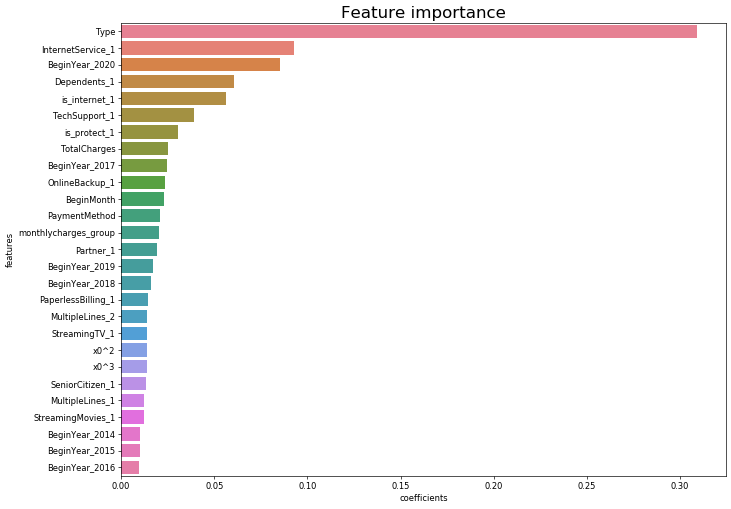

In [26]:
feature_importance(best_xgb.feature_importances_)

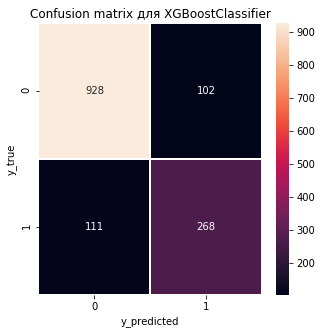

In [27]:
confusion_m(best_xgb, 'Confusion matrix для XGBoostClassifier')

### MLPClassifier

In [28]:
model_mlp = MLPClassifier(hidden_layer_sizes=[5,5,5],random_state = 12345, max_iter = 100)
parameters_mlp = {'activation':['identity', 'logistic', 'tanh', 'relu'],
                  'solver': ['adam', 'sgd', 'lbfgs'],  
                  'learning_rate_init':[0.09, 0.0008, 0.2, 0.009], 
                  'learning_rate': ['constant', 'invscaling', 'adaptive']}
search_mlp = RandomizedSearchCV(model_mlp, parameters_mlp, cv = 5, n_jobs = -1)
search_mlp.fit(X_train, y_train)
best_mlp = search_mlp.best_estimator_
predict_mlp = best_mlp.predict(X_valid)
score_mlp = cross_val_score(best_mlp, X_valid, y_valid, scoring = 'roc_auc', cv = 5, n_jobs = -1)
print('AUC-ROC для MLP на валидационной выборке:', sum(score_mlp)/len(score_mlp))
print('Accuracy для MLP на валидационной выборке:', accuracy_score(y_valid, predict_mlp))

AUC-ROC для MLP на валидационной выборке: 0.8241149229275321
Accuracy для MLP на валидационной выборке: 0.7913413768630234


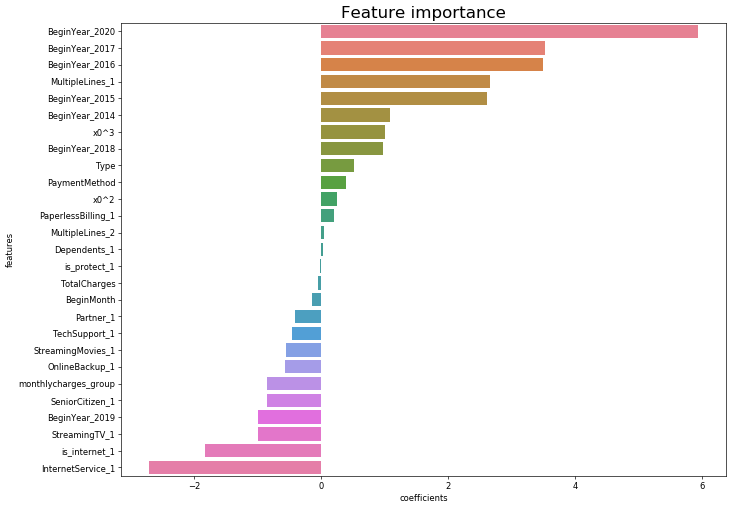

In [29]:
feature_importance(best_mlp.coefs_[0])

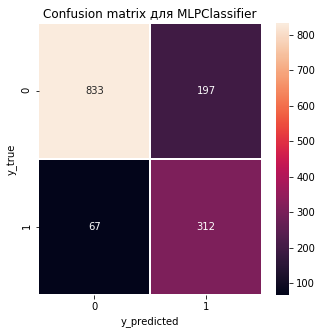

In [30]:
confusion_m(best_mlp, 'Confusion matrix для MLPClassifier')

### Voting Classifier

In [31]:
eclf = VotingClassifier(estimators=[('mlp', best_mlp), ('lr', best_lr), ('xgb', best_xgb), ('rf', best_rf)], voting='soft')
eclf.fit(X_train, y_train)
predict_eclf = eclf.predict(X_valid)
score_eclf = cross_val_score(eclf, X_valid, y_valid, scoring = 'roc_auc', cv = 5, n_jobs = -1)
print('AUC-ROC для ансамбля моделей валидационной выборке:', sum(score_eclf)/len(score_eclf))
print('Accuracy для ансамбля моделей валидационной выборке:', accuracy_score(y_valid, predict_eclf))

AUC-ROC для ансамбля моделей валидационной выборке: 0.8565821379137744
Accuracy для ансамбля моделей валидационной выборке: 0.8211497515968772


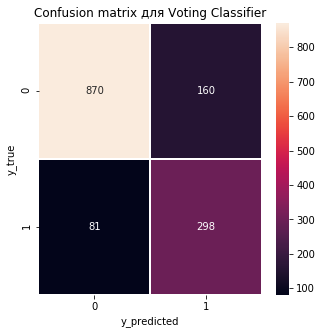

In [32]:
confusion_m(eclf, 'Confusion matrix для Voting Classifier')

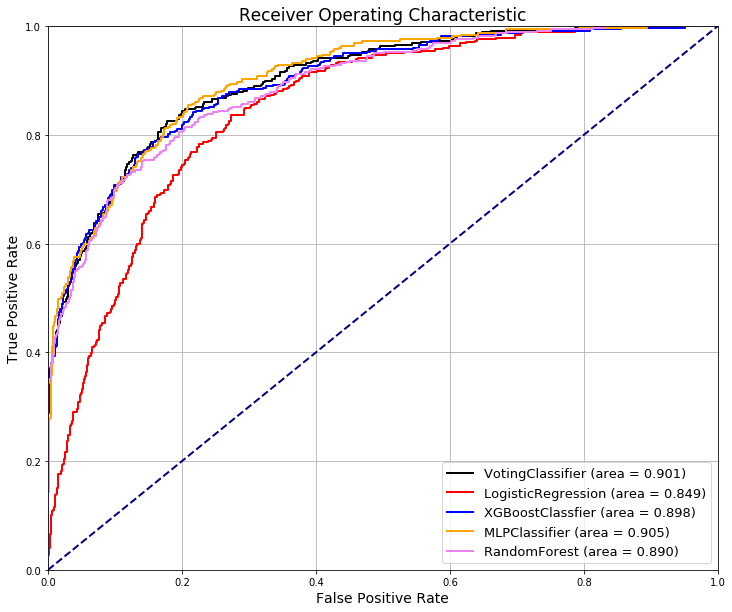

In [33]:
# Построим графики для всех моделей
plt.figure(figsize=(12,10))
probabilities_one_vc = eclf.predict_proba(X_test)
probabilities_one_vc = probabilities_one_vc[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_vc)
plt.plot(fpr, tpr, color = 'black',
        lw = 2, label = 'VotingClassifier (area = %0.3f)' % roc_auc_score(y_test, probabilities_one_vc))
probabilities_one_lr = best_lr.predict_proba(X_test)
probabilities_one_lr = probabilities_one_lr[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_lr)
plt.plot(fpr, tpr, color='red',
        lw = 2, label = 'LogisticRegression (area = %0.3f)' % roc_auc_score(y_test, probabilities_one_lr))
probabilities_one_xgb = best_xgb.predict_proba(X_test)
probabilities_one_xgb = probabilities_one_xgb[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_xgb)
plt.plot(fpr, tpr, color = 'blue',
        lw = 2, label = 'XGBoostClassfier (area = %0.3f)' % roc_auc_score(y_test, probabilities_one_xgb))
probabilities_one_mlp = best_mlp.predict_proba(X_test)
probabilities_one_mlp = probabilities_one_mlp[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_mlp)
plt.plot(fpr, tpr, color = 'orange',
        lw = 2, label = 'MLPClassifier (area = %0.3f)' % roc_auc_score(y_test, probabilities_one_mlp))
probabilities_one_rf = best_rf.predict_proba(X_test)
probabilities_one_rf = probabilities_one_rf[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_rf)
plt.plot(fpr, tpr, color = 'violet',
        lw = 2, label = 'RandomForest (area = %0.3f)' % roc_auc_score(y_test, probabilities_one_rf))
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize= 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Receiver Operating Characteristic', fontsize = 17)
plt.legend(loc = 'lower right', fontsize = 13)
plt.grid()
plt.show()

In [34]:
# Рассчитаем для всех моделей среднее AUC-ROC
auc_roc_lr_test = cross_val_score(best_lr, X_test, y_test, scoring = 'roc_auc', cv = 20, n_jobs = -1)
mean_auc_roc_lr_test = sum(auc_roc_lr_test)/len(auc_roc_lr_test)
auc_roc_rf_test = cross_val_score(best_rf, X_test, y_test, scoring = 'roc_auc', cv = 10, n_jobs = -1)
mean_auc_roc_rf_test = sum(auc_roc_rf_test)/len(auc_roc_rf_test)
auc_roc_xgb_test = cross_val_score(best_xgb, X_test, y_test, scoring = 'roc_auc', cv = 10, n_jobs = -1)
mean_auc_roc_xgb_test = sum(auc_roc_xgb_test)/len(auc_roc_xgb_test)
auc_roc_mlp_test = cross_val_score(best_mlp, X_test, y_test, scoring = 'roc_auc', cv = 10, n_jobs = -1)
mean_auc_roc_mlp_test = sum(auc_roc_mlp_test)/len(auc_roc_mlp_test)
auc_roc_eclf_test = cross_val_score(eclf, X_test, y_test, scoring = 'roc_auc', cv = 10, n_jobs = -1)
mean_auc_roc_eclf_test = sum(auc_roc_eclf_test)/len(auc_roc_eclf_test)
data_for_score = [['logistic-regression', mean_auc_roc_lr_test, accuracy_score(y_test, best_lr.predict(X_test))], 
                  ['xgboost', mean_auc_roc_xgb_test, accuracy_score(y_test, best_xgb.predict(X_test))], 
                  ['MLP', mean_auc_roc_mlp_test, accuracy_score(y_test, best_mlp.predict(X_test))], 
                  ['random_forest', mean_auc_roc_rf_test, accuracy_score(y_test, best_rf.predict(X_test))], 
                  ['Voting Classifier', mean_auc_roc_eclf_test, accuracy_score(y_test, eclf.predict(X_test))]]
columns_for_score = ['model', 'mean_roc_auc', 'accuracy']
table_for_score = pd.DataFrame(data = data_for_score, columns = columns_for_score)
table_for_score

,model,mean_roc_auc,accuracy
0,logistic-regression,0.858396,0.779986
1,xgboost,0.881321,0.848829
2,MLP,0.843771,0.812633
3,random_forest,0.883066,0.819730
4,Voting Classifier,0.881491,0.828957


## Отчёт по решению



<p style='text-indent: 3%;'>
Работа была выполнена практически по плану, предложенному ранее. Стоит отметить, что к плану было добавлено несколько дополнительных подпунктов: </p> 
<ol> 1. были применены технологии преобразования категориальных признаков в численные (в изначальном датафрейме много  категориальных признаков, некоторые же алгоритмы ML ожидают, что на входе будут численные значения, поэтому необходимо их    преобразовать); </ol>
<ol> 2. стандартизация численных значений (для того, чтобы большие значения или разбросы не были в приоритете для модели); </ol>
<ol> 3. избавление от дисбаланса (по умолчанию - модели считают, что все объекты обучающей выборки равнозначны, в нашем  же случае наблюдается дисбаланс объектов, что может сказаться на обучении модели, если не применить меры по уравновешеванию классов); </ol>
<ol> 4. генерация полиномиальных признаков (расширение признаков для того, чтобы модель лучше устанавливала взаимосвязь  между данными). </ol> 
<p style='text-indent: 3%;'>В ходе работы возникли проблемы, связанные с качеством модели, а именно-при первоначальной подготовке данных модель (при использовании только продолжительности жизни клиентов) не давала AUC-ROC выше 0.85. После того, как ни нейросети, ни ансамбли (стекинг) особо не исправили ситуацию, решил вернуться к подготовке данных: написал ещё пару функций категоризации, использовал месяц и год начала контракта вместо продолжительности жизни.</p>       
<p style='text-indent: 3%;'>Ключевым моментом в решении задачи считаю подготовку данных - в этом этапе можно как упростить себе задачу, так и усложнить.</p> 
<p style='text-indent: 3%;'>Наилучший (~0.9) и более стабильный результат выдает ансамбль моделей VotingClassifier, способный выдать схожий результат  не только в тестовой выборке, но и в "бою". Несмотря на экономические затраты на такую модель, думаю, что такая модель окупит себя предсказанием клиентов, которые собираются уйти.</p>